# Ames housing prices
An exploration of predictor variables and evaluation of prediction models

## Problem Statement
For the unseasoned consumer or developer, the price mechanisms of the property market can be a mystery. What factors drive prices can seem to vary from market to market, making it hard to make informed decisions when participating in the market. The nebulous nature of housing prices poses problems to all market participants. As a buyer, I want to know what is the fair value of the property I'm looking to buy. I would ask myself, "Am I being overcharged for this particular property? Or how can I get a similar property for lower?". As a seller or developer, I'd ask myself, "What can I do to increase the value of my property? Where should I look to build my next project if I want to maximize profits?"

This project seeks to create a regression model that can accurately predict housing prices given a number of predictor variables, and help buyers and sellers alike answer the above questions. We will use RMSE as our error metric and seek to minimize this error, ensuring that our model is as accurate as possible. Additionally, we seek to ensure this model remains generalizable to future unseen data. Our model shall hopefully be of use to everyone, buyer and seller alike.

## Executive Summary
This project seeks to understand the relationship of house prices in Ames, Iowa, with a set of 80 different housing related variables. Examples of such variables include the total above ground living area, the neighborhood the property is located in, and the year the property was built. We seek to build a regression model that can use a number of these variables to accurately predict future house prices when used on new, unseen data. 

The methodology of this project is straightforward:

    1. Clean our data
        - including preparing data for exploratory data analysis by performing the appropriate transformations such as splitting data in train and validation sets.
    2. Perform our EDA
        - we will employ the use of summary statistics and visualizations such as scatterplots, heatmaps, and boxplots.
    3. Preprocess our data
    4. Model our data
        - we employ multiple linear regression, ridge, lasso, and elasticnet models.
    5. Evaluate models.
        - the metric used shall be Root Mean Squared Error (RMSE).
Results show that the optimal model to use is the **Lasso regression model with 30 predictor variables**. The model display a good balance between prediction power and generalizability without making our model overly complex, as the difference in performance between our training and validation sets is a reasonable RMSE of 1000 or so. The exact details of this model's implementation are included in our model evaluation.

We find that the top predictors that explain housing prices are the neighborhood the property is located in, the various size dimensions of the property, as well as variables detailing the quality of various aspects of the property. Recommendations for future action include the **exploration of interaction effects** between our existing variables and **building individual regression models for each neighborhood** to account for the difference in importance of various predictors between neighborhoods.

Some limitations of this project include being unable to comprehensively explore all possible interaction effects of our predictors, as that requires more time and computing resources. We also chose to favor a lower complexity model here, so it is like that our model could be finetuned further if we are willing to accept an increase in model complexity. We would also benefit from having more data as a whole, and having that data be more complete as well.

## Start off by importing our libraries

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import math

%matplotlib inline

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

In [2]:
# some matplotlib params to make the defaults a bit more readable
mpl.rcParams['figure.figsize'] = [8.0, 6.0]
mpl.rcParams['font.size'] = 12
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

## Our workflow to clean our data
The steps we need to take are:
1. Impute null values that can be reasoned about
    - these are values that I can figure out by looking at the data dictionary, or by observing related columns
    - for e.g. if I have NaN Garage Type, I know that I don't have a Garage, so I can put Garage Area to be 0.
2. Encode our ordinal variables on an integer scale, apply datatype transformations on columns as necessary.
    - Decide whether there are any columns we want to drop.
3. Split our data into train and validation sets.
4. For our remaining null values, decide how we want to impute the values.
    - We could impute using the median for continuous variables, or the mode for categorical variables.

#### Import our training data

In [3]:
df = pd.read_csv('./datasets/train.csv')
df.head()

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
0,109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,130500
1,544,531379050,60,RL,43.0,11492,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,4,2009,WD,220000
2,153,535304180,20,RL,68.0,7922,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,1,2010,WD,109000
3,318,916386060,60,RL,73.0,9802,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,4,2010,WD,174000
4,255,906425045,50,RL,82.0,14235,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,138500


In [4]:
# get a quick sense of the dtypes and number of null values per column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 81 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Id               2051 non-null   int64  
 1   PID              2051 non-null   int64  
 2   MS SubClass      2051 non-null   int64  
 3   MS Zoning        2051 non-null   object 
 4   Lot Frontage     1721 non-null   float64
 5   Lot Area         2051 non-null   int64  
 6   Street           2051 non-null   object 
 7   Alley            140 non-null    object 
 8   Lot Shape        2051 non-null   object 
 9   Land Contour     2051 non-null   object 
 10  Utilities        2051 non-null   object 
 11  Lot Config       2051 non-null   object 
 12  Land Slope       2051 non-null   object 
 13  Neighborhood     2051 non-null   object 
 14  Condition 1      2051 non-null   object 
 15  Condition 2      2051 non-null   object 
 16  Bldg Type        2051 non-null   object 
 17  House Style   

In [5]:
# take a closer look at only the variables with null values
df[df.columns[df.isna().sum()>0]].isna().sum()

Lot Frontage       330
Alley             1911
Mas Vnr Type        22
Mas Vnr Area        22
Bsmt Qual           55
Bsmt Cond           55
Bsmt Exposure       58
BsmtFin Type 1      55
BsmtFin SF 1         1
BsmtFin Type 2      56
BsmtFin SF 2         1
Bsmt Unf SF          1
Total Bsmt SF        1
Bsmt Full Bath       2
Bsmt Half Bath       2
Fireplace Qu      1000
Garage Type        113
Garage Yr Blt      114
Garage Finish      114
Garage Cars          1
Garage Area          1
Garage Qual        114
Garage Cond        114
Pool QC           2042
Fence             1651
Misc Feature      1986
dtype: int64

We quickly examine the relationship between each numeric variable and `SalePrice` to identify any potential relationships and identify any outliers. Some columns are not properly encoded yet but we will settle that later.

In [6]:
def subplot_scatter(pred_vars, target_var='SalePrice', df=df):
    """
    target_var: target variable of choice. pass as a string.
    pred_vars: predictor variables of choice. pass in as a list.
    df: dataframe the variables come from.
    """
    ncols = 4
    nrows = math.ceil(len(pred_vars)/4)
    fig, ax = plt.subplots(ncols = ncols, nrows = nrows, figsize = (15, 3 * nrows))
    ax = ax.ravel()
    for n, var in enumerate(pred_vars):
        sns.regplot(data=df, 
                        x=var, 
                        y=target_var, 
                        ci=False, 
                        ax = ax[n],
                        line_kws = {'color':'red'})
    plt.tight_layout()

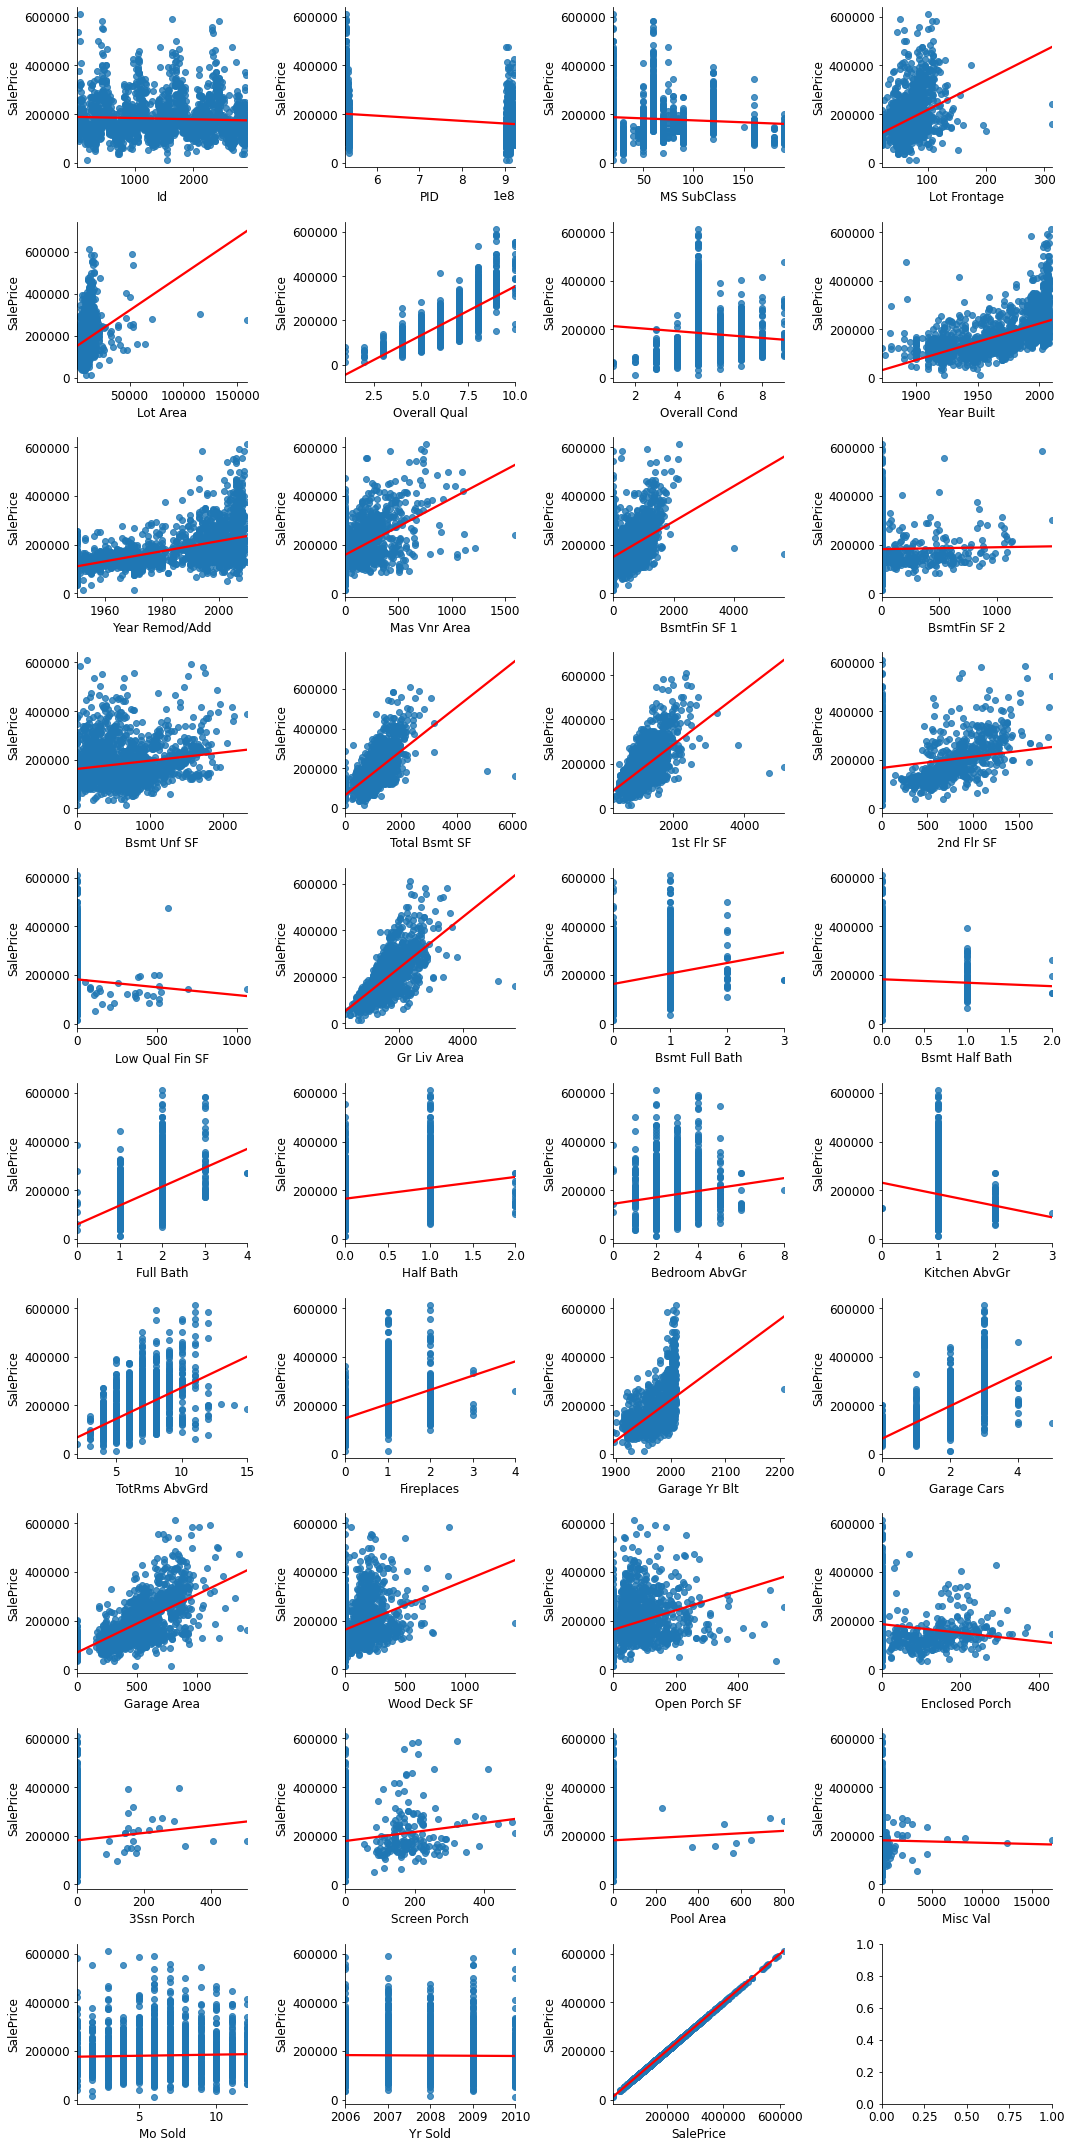

In [7]:
subplot_scatter(df._get_numeric_data().columns);

Some plots seem to indicate outliers. 2 large values for Gr Liv Area (> 4000 sq ft) show disproportionately low sale prices. The data dictionary suggests these are abnormally low sale prices too and recommends excluding them. There is also a Garage Yr Built value of >2200, which is not possible. We will reset the garage year built to be the same as the Year Built as that is a reasonable assumption to make.

In [8]:
# exclude rows where Gr Liv Area > 4000
df = df[df['Gr Liv Area'] < 4000].copy()
# set Garage Yr Blt to Year Built for outlier
df.loc[df['Garage Yr Blt'] > 2200, 'Garage Yr Blt'] = df.loc[df['Garage Yr Blt'] > 2200, 'Year Built']
# check that there are no more garages built in the future
df[df['Garage Yr Blt'] > 2010][['Year Built', 'Garage Yr Blt']]

,Year Built,Garage Yr Blt


We can already observe that some variables appear to have decent correlations with `SalePrice`. Some examples are `Overall Qual, Gr Liv Area, 1st Flr SF, Total Bsmt SF` and to a lesser extent `Year Built, Year Remod/Add`. We will keep this is mind for later on.

## Imputing null values, encoding ordinal variables
#### Working on columns that are logically grouped together
We should be able to deduce, either from the data dictionary or through logic, what some or even all of these null values should be. By fixing these null values here, we will improve the quality of our data exploration later on. We will not one-hot encode nominal variables **at this point** to facilitate our initial EDA. The goal here is to figure out what our null values mean so that we either impute it or encode them into our ordinal variables.

#### 'Lot' related variables

In [9]:
# look at related columns
df[df.columns[df.columns.str.contains('Lot')]].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2049 entries, 0 to 2050
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Lot Frontage  1719 non-null   float64
 1   Lot Area      2049 non-null   int64  
 2   Lot Shape     2049 non-null   object 
 3   Lot Config    2049 non-null   object 
dtypes: float64(1), int64(1), object(2)
memory usage: 80.0+ KB


In [10]:
# Lot Shape is ordinal and Lot Config is nominal. We will label encode Lot Shape with a scale of 0-3
df['Lot Shape'] = df['Lot Shape'].map({'IR3':0, 'IR2':1, 'IR1':2, 'Reg':3})

In [11]:
# check Lot Shape is now int (ordinal scale)
df[df.columns[df.columns.str.contains('Lot')]].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2049 entries, 0 to 2050
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Lot Frontage  1719 non-null   float64
 1   Lot Area      2049 non-null   int64  
 2   Lot Shape     2049 non-null   int64  
 3   Lot Config    2049 non-null   object 
dtypes: float64(1), int64(2), object(1)
memory usage: 80.0+ KB


We shall leave the imputation of Lot Frontage for later, as we likely need to perform some simple imputation on it.

####  'Pool' related variables
There are many null values for the Pool QC column. Examine all Pool related columns.

In [12]:
df[df.columns[df.columns.str.contains('Pool')]].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2049 entries, 0 to 2050
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Pool Area  2049 non-null   int64 
 1   Pool QC    8 non-null      object
dtypes: int64(1), object(1)
memory usage: 48.0+ KB


Apparently only 8 houses in Ames have a pool. Anything pool related is unlikely to be a useful predictor because there are just too many houses with no pool. Going forward, any categorical variable that has **more than 90% of its values** belonging to a single label should be considered for dropping if they do not help us predict anything. For now we will drop all Pool related variables

In [13]:
# lets go ahead and drop both pool variables.
df.drop(columns=['Pool Area','Pool QC'], inplace=True)

####  'Garage' related variables
Let's examine garage variables next.

In [14]:
df[df.columns[df.columns.str.contains('Garage')]].isna().sum()

Garage Type      113
Garage Yr Blt    114
Garage Finish    114
Garage Cars        1
Garage Area        1
Garage Qual      114
Garage Cond      114
dtype: int64

In [15]:
# lets check out the 1 missing value for garage cars and garage area and see if we can impute directly from source data
garage_cols = df.columns[df.columns.str.contains('Garage')]
df[(df['Garage Cars'].isna()) | (df['Garage Area'].isna())]\
   [list(garage_cols)+['PID']]

,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,PID
1712,Detchd,NaN,NaN,NaN,NaN,NaN,NaN,910201180


Looking up PID 910201180 on the Beacon website, we see that the property has no garage, so let's impute 0 for `Garage Cars` and `Garage Area`. We also change the Garage Type from Detched to np.nan

In [16]:
df.loc[1712, ['Garage Cars','Garage Area']] = 0
df.loc[1712, 'Garage Type'] = np.nan

In [17]:
# check the 114 null values to see if they belong to houses that have no garage, i.e. the sum of Garage Area is 0.
df[df['Garage Qual'].isna()]['Garage Area'].sum() # we can assume it is the same houses with nulls for these variables

0.0

The remaining 114 null values for the other Garage variables come from houses with no garages. Apart from Garage Yr Blt, the rest are categorical variables that will either be encoded with dummy columns or labels. For Garage Yr Blt, I hypothesize that Garage Yr Blt is highly correlated with Year Built as most garages are likely to be built together with the house, and as such I am likely going to leave it out of our model to reduce collinearity. To confirm this, we check the correlation of Year Built, Garage Yr Built, and SalePrice. 


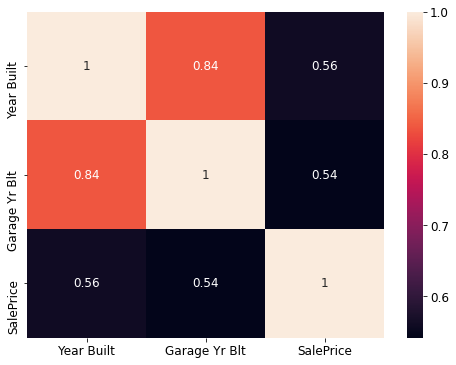

In [18]:
sns.heatmap(df[df['Garage Yr Blt'].notna()][['Year Built','Garage Yr Blt','SalePrice']].corr(), annot=True);

As Year Built and Garage Yr Blt are highly correlated, we suspect they may also be multicollinear when predicting price. For a model that uses non-multicollinear predictor variables, the addition or subtraction of any predictor variable should not have an effect on the coefficients obtained for the other variables. Let us observe whether Yr Built is multicollinear with Garage Yr Built when predicting SalePrice. If they are highly multicollinear, we will observe a change in beta for the same predictor between different models. 

In [19]:
y = df[df['Garage Yr Blt'].notna()]['SalePrice']
# create 3 different sets of predictors to fit our model on.
X1 = df[df['Garage Yr Blt'].notna()][['Year Built', 'Garage Yr Blt']]
X2 = df[df['Garage Yr Blt'].notna()][['Year Built']]
X3 = df[df['Garage Yr Blt'].notna()][['Garage Yr Blt']]
# print out the betas for each predictor for each model
for model_pred in [X1,X2,X3]:
    lr = LinearRegression()
    lr.fit(model_pred,y)
    print (f'Model that uses {list(model_pred.columns)}')
    for n,col in enumerate(model_pred.columns):
        print(f'Beta for {col} is: {lr.coef_[n]}')
    print('----------')


Model that uses ['Year Built', 'Garage Yr Blt']
Beta for Year Built is: 973.4797694222289
Beta for Garage Yr Blt is: 760.0803600099676
----------
Model that uses ['Year Built']
Beta for Year Built is: 1516.3803049071623
----------
Model that uses ['Garage Yr Blt']
Beta for Garage Yr Blt is: 1716.9448023638065
----------


We see that the betas for Year Built and Garage Yr Blt vary a lot between models, so we know that they are multicollinear when predicting SalePrice. Based on this, I know that I am unlikely to use both these variables together in my final model, and thus I will just impute the value of Year Built onto the null values of Garage Yr Blt for now.

In [20]:
df.loc[df['Garage Yr Blt'].isna(),'Garage Yr Blt'] = df.loc[df['Garage Yr Blt'].isna(),'Year Built'] 
# check that there are no more null values for Garage Yr Blt
df['Garage Yr Blt'].isna().sum()

0

In [21]:
# start coding the ordinal values using integers according to the data dictionary.
# we will set null values to 0 so that they do not get affected by our coefficients
df['Garage Qual'] = df['Garage Qual'].map({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}).fillna(0)
df['Garage Cond'] = df['Garage Cond'].map({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}).fillna(0)
df['Garage Finish'] = df['Garage Finish'].map({'Unf':1, 'RFn':2, 'Fin':3}).fillna(0)

In [22]:
# do a final null check
df[df.columns[df.columns.str.contains('Garage')]].isna().sum()

Garage Type      114
Garage Yr Blt      0
Garage Finish      0
Garage Cars        0
Garage Area        0
Garage Qual        0
Garage Cond        0
dtype: int64

We will handle the null values for Garage Type later when we dummy encode our nominal variables. For now, save our progress so far to a new csv.

In [23]:
df.to_csv('./datasets/train_clean.csv', index=False)

In [24]:
# read this in to resume cleaning from this point
# df = pd.read_csv('./datasets/train_partlyclean.csv')

#### 'Bsmt' related variables

In [25]:
# look at null values
all_bsmt = df.columns[df.columns.str.contains('Bsmt')]
df[all_bsmt].isna().sum()

Bsmt Qual         55
Bsmt Cond         55
Bsmt Exposure     58
BsmtFin Type 1    55
BsmtFin SF 1       1
BsmtFin Type 2    56
BsmtFin SF 2       1
Bsmt Unf SF        1
Total Bsmt SF      1
Bsmt Full Bath     2
Bsmt Half Bath     2
dtype: int64

In [26]:
# impute null values to 0 for continuous Bsmt variables.
cont_bsmt = ['BsmtFin SF 1','BsmtFin SF 2', 'Total Bsmt SF', 'Bsmt Unf SF']
for col in cont_bsmt:
    df[col].fillna(0, inplace=True)

In [27]:
# next we look at rows where Total Bsmt SF == 0. having no basements means we know that null values are 
# not missing, but refer to absence of a basement for categorical 
df[df['Total Bsmt SF'] ==0][all_bsmt].isna().sum()

Bsmt Qual         55
Bsmt Cond         55
Bsmt Exposure     55
BsmtFin Type 1    55
BsmtFin SF 1       0
BsmtFin Type 2    55
BsmtFin SF 2       0
Bsmt Unf SF        0
Total Bsmt SF      0
Bsmt Full Bath     2
Bsmt Half Bath     2
dtype: int64

In [28]:
# we can impute 0 for discrete variables for these houses
df.loc[df['Total Bsmt SF'] ==0, ['Bsmt Full Bath', 'Bsmt Half Bath']] = 0

In [29]:
# there are 3 more null values for Bsmt Exposure than the other variables. let's check why this is so
display(df[df['Bsmt Exposure'].isna() & df['Bsmt Qual'].notna()][list(all_bsmt)+['PID']])

,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Bsmt Full Bath,Bsmt Half Bath,PID
1456,Gd,TA,NaN,Unf,0.0,Unf,0.0,725.0,725.0,0.0,0.0,528458090
1547,Gd,TA,NaN,Unf,0.0,Unf,0.0,1595.0,1595.0,0.0,0.0,528445060
1997,Gd,TA,NaN,Unf,0.0,Unf,0.0,936.0,936.0,0.0,0.0,907194130


In [30]:
# these houses obviously have basements so these are true missing values.
# unfortunately, this information cannot be found by searching the PIDs. we will impute this later after splitting.
# we temporarily fill these with "replace with mode" so that we can use fillna on the real null/no-garage values.
# after label encoding, we can set it back to np.nan for later imputation.
df.loc[df['Bsmt Exposure'].isna() & df['Bsmt Qual'].notna(),'Bsmt Exposure'] = "replace with mode"

In [31]:
df.loc[df['Bsmt Exposure']=='replace with mode','Bsmt Exposure']

1456    replace with mode
1547    replace with mode
1997    replace with mode
Name: Bsmt Exposure, dtype: object

In [32]:
# check the 56th null value under BsmtFin Type 2
display(df[df['BsmtFin Type 2'].isna() & df['Bsmt Qual'].notna()][list(all_bsmt)+['PID']])

,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Bsmt Full Bath,Bsmt Half Bath,PID
1147,Gd,TA,No,GLQ,1124.0,NaN,479.0,1603.0,3206.0,1.0,0.0,528142130


In [33]:
# this is also a true missing value, we will figure out what to impute after splitting
# for now, replace it with "replace with mode" like above, then set it back to np.nan later
df.loc[df['BsmtFin Type 2'].isna() & df['Bsmt Qual'].notna(), 'BsmtFin Type 2'] = "replace with mode"

In [34]:
# label encode our ordinal columns
df.replace({'Bsmt Qual': {'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
              'Bsmt Cond': {'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
              'Bsmt Exposure': {'No':1, 'Mn':2, 'Av':3, 'Gd':4},
              'BsmtFin Type 1': {'Unf':1, 'LwQ':2, 'Rec':3, 'BLQ':4, 'ALQ':5, 'GLQ':6},
              'BsmtFin Type 2': {'Unf':1, 'LwQ':2, 'Rec':3, 'BLQ':4, 'ALQ':5, 'GLQ':6}}, inplace=True)
# set our nulls to 0 in our encoding scheme
for var in ['Bsmt Qual','Bsmt Cond','Bsmt Exposure','BsmtFin Type 1','BsmtFin Type 2']:
    df[var].fillna(0, inplace=True)

In [35]:
# reset our true missing values to np.nan
df.loc[df['Bsmt Exposure']=='replace with mode','Bsmt Exposure'] = np.nan
df.loc[df['BsmtFin Type 2']=='replace with mode','BsmtFin Type 2'] = np.nan

In [36]:
# check that only true missing values remain
df[all_bsmt].isna().sum()

Bsmt Qual         0
Bsmt Cond         0
Bsmt Exposure     3
BsmtFin Type 1    0
BsmtFin SF 1      0
BsmtFin Type 2    1
BsmtFin SF 2      0
Bsmt Unf SF       0
Total Bsmt SF     0
Bsmt Full Bath    0
Bsmt Half Bath    0
dtype: int64

### CHECKPOINT
Save our partially clean data again.

In [37]:
df.to_csv('./datasets/train_clean.csv', index=False)

In [38]:
#check for current null values
df[df.columns[df.isna().sum()>0]].isna().sum()

Lot Frontage       330
Alley             1909
Mas Vnr Type        22
Mas Vnr Area        22
Bsmt Exposure        3
BsmtFin Type 2       1
Fireplace Qu      1000
Garage Type        114
Fence             1649
Misc Feature      1985
dtype: int64

#### Decide whether to drop Alley and Misc Feature as they have >90% null values
While these null values are not actual missing values, they do represent a significant majority of the values in the variable. As such, we should drop them as they will not be useful in predicting SalePrice.

In [39]:
# we drop Misc Value alongside Misc Feature as these variables are related.
df.drop(columns = ['Alley', 'Misc Feature', 'Misc Val'], inplace=True)

#### Fireplace Qu, Fence, Mas Vnr Type, Mas Vnr Area
These are the final 4 variables to tackle. Let's finish cleaning up our nulls.

In [40]:
# Fence is a ordinal variable where null value means no fence, 
# so we label encode Fence using a scale of 0-4
df['Fence'] = df['Fence'].map({'MnWw': 1, 'GdWo': 2, 'MnPrv': 3, 'GdPrv': 4}).fillna(0)

In [41]:
# Fireplace Qu is ordinal, where NA means no fireplace. we can double check this number (1000) against Fireplaces == 0
(df['Fireplaces'] == 0).sum()

1000

In [42]:
# thus we label encode using a scale of 0-5
df['Fireplace Qu'] = df['Fireplace Qu'].map({'NA':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}).fillna(0)

In [43]:
df[df.columns[df.isna().sum()>0]].isna().sum()
# these values all require some imputation except for Garage Type, which is a nominal variable that we dummy encode later.

Lot Frontage      330
Mas Vnr Type       22
Mas Vnr Area       22
Bsmt Exposure       3
BsmtFin Type 2      1
Garage Type       114
dtype: int64

### Encoding all ordinal variables
With most of our null values settled, we can work on encoding the rest of our ordinal variables on an integer scale.

In [44]:
df.replace({'Exter Qual': {'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
              'Exter Cond': {'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
              'Heating QC': {'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
              'Kitchen Qual': {'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
              'Utilities': {'ELO':0, 'NoSeWa':1, 'NoSewr':2, 'AllPub':3},
              'Land Slope': {'Sev':0, 'Mod':1, 'Gtl':2},
              'Electrical': {'Mix':0, 'FuseP':1, 'FuseF':2, 'FuseA':3, 'SBrkr':4},
              'Functional': {'Sal':0,'Sev':1,'Maj2':2,'Maj1':3,'Mod':4,'Min2':5,'Min1':6,'Typ':7},
              'Paved Drive': {'N':0, 'P':1, 'Y':2}}, 
              inplace=True)

### Confirm what dtype our discrete variables should be
We still have some discrete variables like Mo Sold and PID that are encoded as integers. However, it may be more logical to code month as a nominal variable instead. Unfortunately, when writing our dataframes out to csv files, the dtype will not be captured, so if we read back in the same data in another notebook, they will be read as integers again. We can only take note of this and ensure that each time we read in our data, we transform these variables to 'object' dtype if need be.

### Take a final look at our entire DataFrame and inspect the null values and dtypes.
The remaining null values should be those that we need to decide on a value for.

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2049 entries, 0 to 2050
Data columns (total 76 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Id               2049 non-null   int64  
 1   PID              2049 non-null   int64  
 2   MS SubClass      2049 non-null   int64  
 3   MS Zoning        2049 non-null   object 
 4   Lot Frontage     1719 non-null   float64
 5   Lot Area         2049 non-null   int64  
 6   Street           2049 non-null   object 
 7   Lot Shape        2049 non-null   int64  
 8   Land Contour     2049 non-null   object 
 9   Utilities        2049 non-null   int64  
 10  Lot Config       2049 non-null   object 
 11  Land Slope       2049 non-null   int64  
 12  Neighborhood     2049 non-null   object 
 13  Condition 1      2049 non-null   object 
 14  Condition 2      2049 non-null   object 
 15  Bldg Type        2049 non-null   object 
 16  House Style      2049 non-null   object 
 17  Overall Qual  

### Checkpoint!
Save your data

In [46]:
df.to_csv('./datasets/train_clean.csv', index=False)

## Split our data into training and validation

In [47]:
y = df['SalePrice']
X = df.drop(columns=['SalePrice'])
X_train, X_val, y_train, y_val = train_test_split(X,y, random_state=42)

In [48]:
# combine the train and val sets separately and save to 2 csvs.
train_train = X_train.merge(y_train, left_index=True, right_index=True)
train_val = X_val.merge(y_val, left_index=True, right_index=True)

In [49]:
train_train.to_csv('./datasets/train_train.csv', index=False)
train_val.to_csv('./datasets/train_val.csv', index=False)

### Begin imputing our values
We start with the train_train set.

In [50]:
train_train = pd.read_csv('./datasets/train_train.csv')

In [51]:
train_train[train_train.columns[train_train.isna().sum()>0]].isna().sum()

Lot Frontage      247
Mas Vnr Type       17
Mas Vnr Area       17
Bsmt Exposure       3
BsmtFin Type 2      1
Garage Type        86
dtype: int64

We see from the data dictionary that `Lot Frontage` is a continuous variable of linear feet of street connected to property. A check on one house that has a null value for Lot Frontage shows the house being clearly connected to some street in front of it. It is unlikely that a house will not be somewhat connected to a tiny bit of street to it, otherwise how will people exit their houses and get to the road? Because there are so many such null values, it might not be a good idea to impute 0 on all of them. Let's group non-null values by `Neighborhood` get the median for houses in each Neighborhood.

In [52]:
# pivot by neighborhood and aggregate the median lot frontage.
# we will use these values later too when imputing our train_val and test set.
lot_frontage_hood = pd.pivot_table(train_train, values='Lot Frontage', index='Neighborhood',aggfunc=np.median)

In [53]:
def lot_frontage_imputer(df, median_table = lot_frontage_hood):
    # ensure PID is cast as string so we can use str.contains later
    df['PID'] = df['PID'].astype(str)
    for hood in df['Neighborhood'].unique():
        try:
            # generate fake values using the median of that neighborhood
            hood_median = median_table.loc[hood,('Lot Frontage')]
    #         hood_std = lot_frontage_hood.loc[hood,('Lot Frontage','std')]
    #         imputed_vals = np.random.normal(hood_median, hood_std, ames[ames['Neighborhood'] == hood]['Lot Frontage'].isna().sum())
            df.loc[(df['Neighborhood'] == hood) & (df['Lot Frontage'].isna()),
                            'Lot Frontage'] = hood_median
        except:
            print(f'neighborhood {hood} not found in median lookup table')
            # use first 3 digits of PID to find geographically close properties and use their Lot Frontage median.
            print('imputing median based on PID')
            for pid in df.loc[(df['Neighborhood'] == hood) & df['Lot Frontage'].isna(),'PID']:
                pid_head = pid[:3] # extract the town and section code
                pid_median = df[df['PID'].str.startswith(pid_head)]['Lot Frontage'].median() # get the median for that area
                df.loc[(df['PID'] == pid) & (df['Lot Frontage'].isna()), 'Lot Frontage'] = pid_median
            # use this PID's median as the neighborhood median instead
            new_row = pd.Series(data = {'Lot Frontage':pid_median}, name = hood)
            # append this to our median lookup table
            median_table = median_table.append(new_row, ignore_index=False)
    return median_table

In [54]:
# we assign back the output of our function to our lot frontage table as it now includes the median gleaned from the PID
# in cases where Neighborhood was missing
lot_frontage_hood = lot_frontage_imputer(train_train)

neighborhood Landmrk not found in median lookup table
imputing median based on PID
neighborhood GrnHill not found in median lookup table
imputing median based on PID


In [55]:
# fix our Bsmt variables
train_train[train_train['BsmtFin Type 2'].isna()][all_bsmt]

,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Bsmt Full Bath,Bsmt Half Bath
2,4.0,3.0,1.0,6.0,1124.0,NaN,479.0,1603.0,3206.0,1.0,0.0


In [56]:
# unfortunately, the website won't tell us what this value is, so what we do is
# look at other houses where BsmtFin Type 1 == 6.0, and find their most common value for BsmtFin Type 2
# we'll use that value to impute both the train_train and train_val sets.
train_train[train_train['BsmtFin Type 1']==6]['BsmtFin Type 2'].value_counts()

1.0    433
3.0     15
2.0     11
5.0      8
4.0      4
Name: BsmtFin Type 2, dtype: int64

In [57]:
# impute 1 onto BsmtFin Type 2 null
train_train['BsmtFin Type 2'].fillna(1, inplace=True)

In [58]:
# use sklearn's SimpleImputer to fill in the most frequent values for Bsmt Exposure, Mas Vnr Type, and Mas Vnr Area
# we will use this fitted SimpleImputer to impute our train_val set later.
imputer = SimpleImputer(strategy='most_frequent')
imputer.fit(train_train[['Bsmt Exposure','Mas Vnr Type','Mas Vnr Area']])
train_train[['Bsmt Exposure','Mas Vnr Type','Mas Vnr Area']] = \
imputer.transform(train_train[['Bsmt Exposure','Mas Vnr Type','Mas Vnr Area']])

In [59]:
# check that the only nulls left belong to nominal variables
train_train[train_train.columns[train_train.isna().sum()>0]].isna().sum()

Garage Type    86
dtype: int64

### Impute our train_val set

In [60]:
train_val = pd.read_csv('./datasets/train_val.csv')

In [61]:
train_val[train_val.columns[train_val.isna().sum()>0]].isna().sum()

Lot Frontage    83
Mas Vnr Type     5
Mas Vnr Area     5
Garage Type     28
dtype: int64

In [62]:
lot_frontage_imputer(train_val, lot_frontage_hood)

,Lot Frontage
Neighborhood,
Blmngtn,52.0
Blueste,24.0
BrDale,21.0
BrkSide,52.0
ClearCr,83.0
CollgCr,70.0
Crawfor,64.0
Edwards,62.0
Gilbert,63.5


In [63]:
train_val[['Bsmt Exposure','Mas Vnr Type','Mas Vnr Area']] = \
imputer.transform(train_val[['Bsmt Exposure','Mas Vnr Type','Mas Vnr Area']])

In [64]:
# check that the only nulls left belong to nominal variables
train_val[train_val.columns[train_val.isna().sum()>0]].isna().sum()

Garage Type    28
dtype: int64

#### Great, the remaining null values for Garage Type will either be dummy coded out later or the column dropped.

In [65]:
# save our train and val sets
train_train.to_csv('./datasets/train_train_clean.csv', index=False)
train_val.to_csv('./datasets/train_val_clean.csv', index=False)

## Apply the same cleaning procedures to our test set
Now then we have the template for cleaning, we will clean our test set.

In [66]:
test = pd.read_csv('./datasets/test.csv')

In [67]:
test[test.columns[test.isna().sum()>0]].isna().sum()

Lot Frontage      160
Alley             821
Mas Vnr Type        1
Mas Vnr Area        1
Bsmt Qual          25
Bsmt Cond          25
Bsmt Exposure      25
BsmtFin Type 1     25
BsmtFin Type 2     25
Electrical          1
Fireplace Qu      422
Garage Type        44
Garage Yr Blt      45
Garage Finish      45
Garage Qual        45
Garage Cond        45
Pool QC           875
Fence             707
Misc Feature      838
dtype: int64

In [68]:
# drop columns
test.drop(columns = ['Pool Area','Pool QC','Alley', 'Misc Feature', 'Misc Val'], inplace=True)

In [69]:
# set Garage Yr Blt to Year Built
test.loc[test['Garage Yr Blt'].isna(),'Garage Yr Blt'] = test.loc[test['Garage Yr Blt'].isna(),'Year Built'] 

In [70]:
# check why there are 44 null values for Garage Type but 45 for the others.
all_garage = test.columns[test.columns.str.contains('Garage')]
display(test[test['Garage Type'].notna() & test['Garage Cond'].isna()][list(all_garage)+['PID']])
# looking up PID of 903426160 reveals that this house has no garage
# set Garage Cars, Garage Qual to 0, and Garage Type to np.nan
test.loc[765, ['Garage Area','Garage Cars']] = 0
test.loc[765, 'Garage Type'] = np.nan

,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,PID
765,Detchd,1910.0,NaN,1,360,NaN,NaN,903426160


In [71]:
# label encode our ordinal columns
test['Garage Qual'] = test['Garage Qual'].map({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}).fillna(0)
test['Garage Cond'] = test['Garage Cond'].map({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}).fillna(0)
test['Garage Finish'] = test['Garage Finish'].map({'Unf':1, 'RFn':2, 'Fin':3}).fillna(0)
# again, Garage Type is nominal, we leave it as is.

In [72]:
# check Garage nulls
test[test.columns[test.columns.str.contains('Garage')]].isna().sum()
# this is what we expected

Garage Type      45
Garage Yr Blt     0
Garage Finish     0
Garage Cars       0
Garage Area       0
Garage Qual       0
Garage Cond       0
dtype: int64

In [73]:
# check basement nulls to see if they come from houses with no basement
test[test['Total Bsmt SF'] ==0][all_bsmt].isna().sum()

Bsmt Qual         25
Bsmt Cond         25
Bsmt Exposure     25
BsmtFin Type 1    25
BsmtFin SF 1       0
BsmtFin Type 2    25
BsmtFin SF 2       0
Bsmt Unf SF        0
Total Bsmt SF      0
Bsmt Full Bath     0
Bsmt Half Bath     0
dtype: int64

In [74]:
# great, we can encode the rest of our ordinal variables
test.replace({'Bsmt Qual': {'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
              'Bsmt Cond': {'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
              'Bsmt Exposure': {'No':1, 'Mn':2, 'Av':3, 'Gd':4},
              'BsmtFin Type 1': {'Unf':1, 'LwQ':2, 'Rec':3, 'BLQ':4, 'ALQ':5, 'GLQ':6},
              'BsmtFin Type 2': {'Unf':1, 'LwQ':2, 'Rec':3, 'BLQ':4, 'ALQ':5, 'GLQ':6},
              'Lot Shape': {'IR3':0, 'IR2':1, 'IR1':2, 'Reg':3},
              'Exter Qual': {'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
              'Exter Cond': {'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
              'Heating QC': {'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
              'Kitchen Qual': {'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
              'Utilities': {'ELO':0, 'NoSeWa':1, 'NoSewr':2, 'AllPub':3},
              'Land Slope': {'Sev':0, 'Mod':1, 'Gtl':2},
              'Electrical': {'Mix':0, 'FuseP':1, 'FuseF':2, 'FuseA':3, 'SBrkr':4},
              'Functional': {'Sal':0,'Sev':1,'Maj2':2,'Maj1':3,'Mod':4,'Min2':5,'Min1':6,'Typ':7},
              'Paved Drive': {'N':0, 'P':1, 'Y':2},
              'Fence': {'MnWw': 1, 'GdWo': 2, 'MnPrv': 3, 'GdPrv': 4},
              'Fireplace Qu': {'NA':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}},
              inplace=True)
for var in ['Bsmt Qual','Bsmt Cond','Bsmt Exposure','BsmtFin Type 1','BsmtFin Type 2','Fence','Fireplace Qu']:
    test[var].fillna(0, inplace=True)

In [75]:
# use the imputer for Mas Vnr Area and Type
test[['Bsmt Exposure','Mas Vnr Type','Mas Vnr Area']] = \
imputer.transform(test[['Bsmt Exposure','Mas Vnr Type','Mas Vnr Area']])

In [76]:
# we didn't have any null values for Electrical in our training set, so we just impute the most frequent value
test['Electrical'].value_counts()

4.0    814
3.0     48
2.0     15
1.0      1
Name: Electrical, dtype: int64

In [77]:
test['Electrical'].fillna(4, inplace=True)

In [78]:
# impute Lot Frontage using the median table we obtained from our train_train set.
lot_frontage_imputer(test, lot_frontage_hood)

,Lot Frontage
Neighborhood,
Blmngtn,52.0
Blueste,24.0
BrDale,21.0
BrkSide,52.0
ClearCr,83.0
CollgCr,70.0
Crawfor,64.0
Edwards,62.0
Gilbert,63.5


In [79]:
test[test.columns[test.isna().sum()>0]].isna().sum()

Garage Type    45
dtype: int64

In [80]:
# save the cleaned test set
test.to_csv('./datasets/test_clean.csv', index=False)